In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import chisquare, norm
from sklearn.utils import resample

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
from IPython.display import display, Latex
rc('font', size=20)

## Generate data

In [94]:
N = int(1e7)
mu_true, sig_true = 0, 1
mu_gen, sig_gen = 0.5, 1
smearing = 0.0
epsilon = 1e-10

streams = ['truth', 'data', 'gen', 'sim']


# Generate data
truth = np.random.normal(mu_true, sig_true, N)
data = np.random.normal(truth, smearing)
gen = np.random.normal(mu_gen, sig_gen, N)
sim = np.random.normal(gen, smearing)

# Bin data

In [95]:
# bins = [truth.min()]
# i = 0
# while bins[-1] < truth.max() and i < len(bins):
#     for binhigh in np.linspace(bins[i] + 0.1, truth.max(), 200):
#         in_bin = (truth > bins[i]) & (truth < binhigh)
#         in_reco_bin = (data > bins[i]) & (data < binhigh)
#         if np.sum(in_bin) > 0:
#             purity = np.sum(in_bin & in_reco_bin) / np.sum(in_bin)
#             if purity > np.sqrt(0.5):
#                 print(f"{binhigh = }, {purity = }")
#                 i += 1
#                 bins.append(binhigh)
#                 break
#     else:
#         break
# bins = np.array(bins)
#
#np.save("bins", bins)

In [96]:
bins = np.load("bins.npy")
print(f"{len(bins) = }")
n_bins = len(bins)

def digitize_data(data):
    digitized = np.digitize(data, bins)  # Digitize the data
    clipped = np.clip(digitized, 1, n_bins) - 1  # Clip and adjust indices
    return clipped

for stream in streams:
    globals()[stream + '_hist'], _ = np.histogram(globals()[stream], bins)
    globals()[stream + '_digitized'] = digitize_data(globals()[stream])

len(bins) = 6


# Response matrix

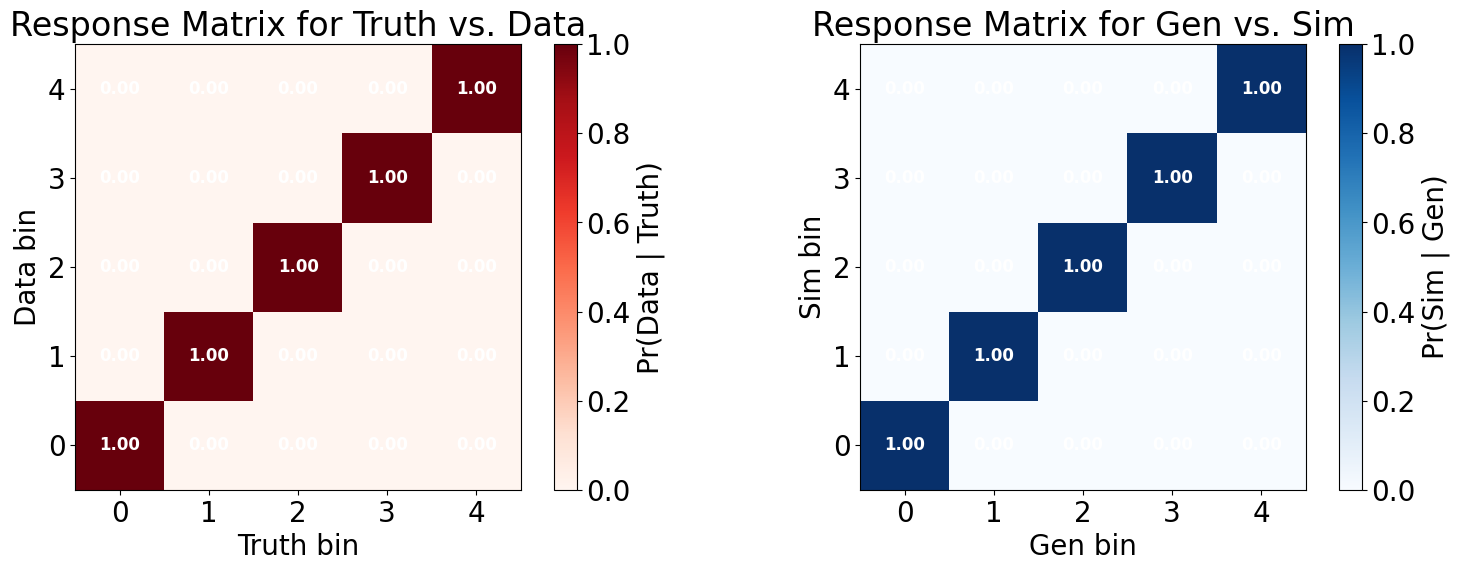

In [97]:
H, _, _ = np.histogram2d(truth_digitized, data_digitized, bins=[range(n_bins), range(n_bins)])
H_alt, _, _ = np.histogram2d(gen_digitized, sim_digitized, bins=[range(n_bins), range(n_bins)])

# Normalize the histogram row-wise
H_normalized = H / (H.sum(axis=1, keepdims=True) + epsilon)
H_normalized_alt = H_alt/(H_alt.sum(axis=1, keepdims=True) + epsilon)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Two plots in one row

# First response matrix
im = axs[0].imshow(H_normalized, origin='lower', cmap="Reds", vmin=0, vmax=1)
for i in range(n_bins-1):
    for j in range(n_bins-1):
        text = axs[0].text(j, i, f"{H_normalized.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[0].set_title("Response Matrix for Truth vs. Data")
axs[0].set_xlabel("Truth bin")
axs[0].set_ylabel("Data bin")
fig.colorbar(im, ax=axs[0], label='Pr(Data | Truth)')

# Second response matrix
im_alt = axs[1].imshow(H_normalized_alt, origin='lower', cmap="Blues", vmin=0, vmax=1)
for i in range(n_bins-1):
    for j in range(n_bins-1):
        text = axs[1].text(j, i, f"{H_normalized_alt.T[i, j]:0.2f}",
                           ha="center", va="center", color="w", fontweight="bold", fontsize=12)
axs[1].set_title("Response Matrix for Gen vs. Sim")
axs[1].set_xlabel("Gen bin")
axs[1].set_ylabel("Sim bin")
fig.colorbar(im_alt, ax=axs[1], label='Pr(Sim | Gen)')

plt.tight_layout()
plt.show()

# IBU



In [98]:
def IBU(prior, data_marginal, alt_response_matrix, n_iterations):
    posterior = [prior]
    for i in range(n_iterations):
        m = alt_response_matrix * posterior[-1]
        m /= (m.sum(axis=1)[:,np.newaxis] + epsilon)
        posterior.append(m.T @ data_marginal)
    return posterior[-1]

In [99]:
truth_marginal = np.sum(H,axis=1)
data_marginal = np.sum(H,axis=0)
sim_marginal = np.sum(H_alt,axis=0)
gen_marginal = np.sum(H_alt,axis=1)
ibu = IBU(gen_marginal, data_marginal, H_normalized_alt.T, 10000)

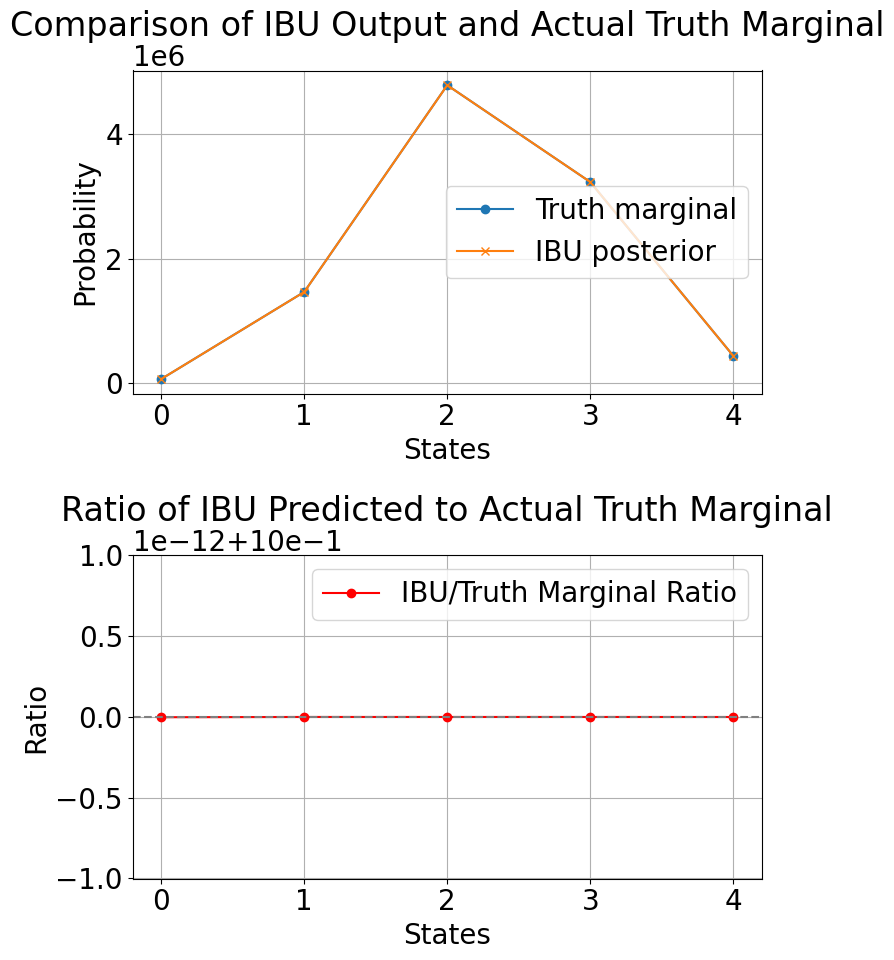

In [100]:
plt.figure(figsize=(8, 10))

# Top panel: Actual vs. Predicted
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first plot
plt.plot(truth_marginal, label='Truth marginal', marker='o')
plt.plot(ibu, label='IBU posterior', marker='x')
plt.title('Comparison of IBU Output and Actual Truth Marginal')
plt.xlabel('States')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)

# Bottom panel: Ratio of IBU to Actual
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second plot
ratio = ibu / truth_marginal
plt.plot(ratio, label='IBU/Truth Marginal Ratio', marker='o', color='red')
plt.title('Ratio of IBU Predicted to Actual Truth Marginal')
plt.xlabel('States')
plt.ylabel('Ratio')
plt.axhline(y=1, color='gray', linestyle='--')  # Add a horizontal line at y=1 for reference
plt.legend()
plt.grid(True)

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area.
plt.show()

# Fit IBU to gaussian

In [101]:
bin_widths = np.diff(bins)
total_area = np.sum(ibu * bin_widths)
ibu_normalized = ibu / total_area

bins_midpoints = 0.5 * (bins[:-1] + bins[1:])

gaussian = lambda x, mu: norm.pdf(x, loc=mu, scale=1)

# Fit Gaussian
params, _ = curve_fit(gaussian, bins_midpoints, ibu_normalized, p0=[0])

mu_ibu = params
print(f"{mu_true = }")
print(f"{mu_ibu = }")

mu_true = 0
mu_ibu = array([0.00965052])


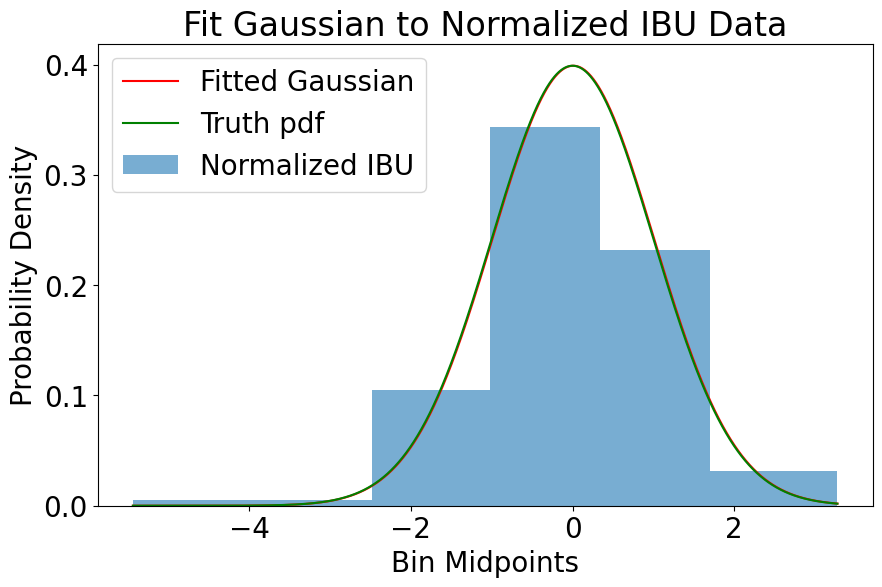

In [102]:
x_values = np.linspace(bins[0], bins[-1], 30000)
gaussian_curve = gaussian(x_values, mu_ibu)
truth_pdf = gaussian(x_values, mu_true)

plt.figure(figsize=(10, 6))
plt.bar(bins_midpoints, ibu_normalized, width=bin_widths, alpha=0.6, label='Normalized IBU')
plt.plot(x_values, gaussian_curve, 'r-', label='Fitted Gaussian')
plt.plot(x_values, truth_pdf, 'g-', label='Truth pdf')
plt.title('Fit Gaussian to Normalized IBU Data')
plt.xlabel('Bin Midpoints')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [109]:
mu_values = np.linspace(min(bins_midpoints), max(bins_midpoints), 10**4)
results = []

for mu in mu_values:
    expected = gaussian(bins_midpoints, mu)
    expected_normalized = expected / np.sum(expected) * np.sum(ibu_normalized)
    chi2, p_value = chisquare(f_obs=ibu_normalized, f_exp=expected_normalized)
    results.append((mu, chi2))

#print("{:<10} {:<10} {:<10}".format("Mu", "Sigma", "Chi-Squared"))
#for res in results:
#    print("{:<10.2f} {:<10.2f}".format(res[0], res[1]))

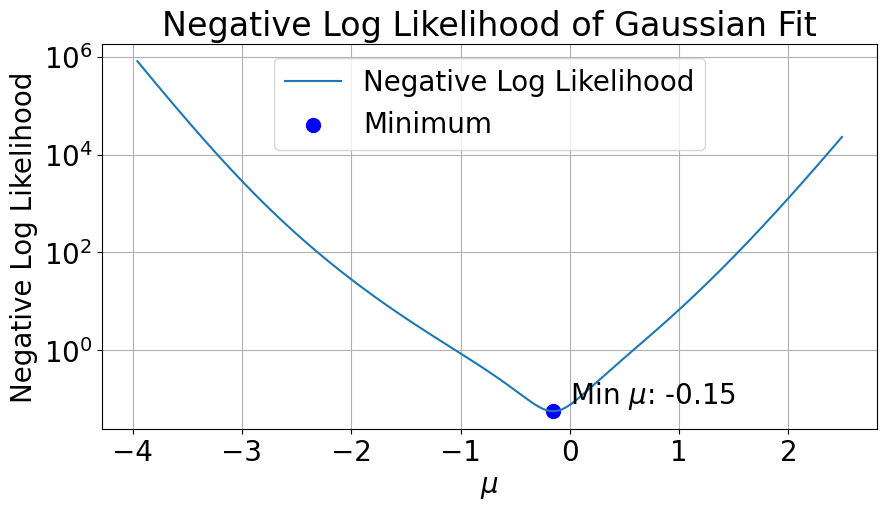

In [110]:
mu_list, chi2_list = zip(*results)
neg_log_likelihood = 0.5 * np.array(chi2_list)

plt.figure(figsize=(10, 5))
plt.plot(mu_list, neg_log_likelihood, label='Negative Log Likelihood')
#plt.scatter(mu_list, neg_log_likelihood, color='red')  # Mark each point

min_index = np.argmin(neg_log_likelihood)
min_mu = mu_list[min_index]
min_nll = neg_log_likelihood[min_index]
plt.scatter(min_mu, min_nll, color='blue', s=100, label='Minimum')  # Mark minimum
plt.text(min_mu, min_nll, fr'  Min $\mu$: {min_mu:.2f}', verticalalignment='bottom')

plt.title('Negative Log Likelihood of Gaussian Fit')
plt.xlabel(r'$\mu$')
plt.ylabel('Negative Log Likelihood')
plt.yscale('log')  # Set the y-scale to logarithmic
plt.legend()
plt.grid(True)

plt.show()

In [111]:
delta_nll = 0.5
within_confidence = np.where(neg_log_likelihood <= min_nll + delta_nll)[0]
if within_confidence.size > 0:
    mu_lower = mu_list[within_confidence[0]]
    mu_upper = mu_list[within_confidence[-1]]
else:
    mu_lower = mu_upper = min_mu  # Edge case if no values are within the interval

error_up = mu_upper - min_mu
error_down = min_mu - mu_lower
display(Latex(f"The 68% confidence interval for $\\mu$ is: $\\mu = {min_mu:.2f}_{{-{error_down:.2f}}}^{{+{error_up:.2f}}}$"))

<IPython.core.display.Latex object>

In [113]:
print(f"[{mu_lower}, {mu_upper}]")

[-0.8700820339209026, 0.449940602974217]


In [114]:
mean_estimated = np.sum(bins_midpoints * ibu_normalized * bin_widths)
variance_estimated = np.sum((bins_midpoints - mean_estimated)**2 * ibu * bin_widths)

# Calculate the Standard Error of the Mean (SEM)
sem = np.sqrt(variance_estimated) / np.sqrt(total_area)

print(f"Estimated Mean: {mean_estimated:.4f}")
print(f"Estimated Variance: {variance_estimated:.4f}")
print(f"Estimated SEM: {sem:.4f}")


Estimated Mean: -0.0360
Estimated Variance: 19257796.4930
Estimated SEM: 1.1743


## Bootstrapping

In [119]:
n_iterations = 10
bootstrap_samples = {
    'truth': [],
    'data': [],
    'gen': [],
    'sim': []
}

for _ in range(n_iterations):
    bs_indices = resample(np.arange(N), replace=True)  # Bootstrap indices

    bootstrap_samples['truth'].append(truth[bs_indices])
    bootstrap_samples['data'].append(data[bs_indices])
    bootstrap_samples['gen'].append(gen[bs_indices])
    bootstrap_samples['sim'].append(sim[bs_indices])

In [120]:
digitized_samples = {
    'truth': [],
    'data': [],
    'gen': [],
    'sim': []
}

for dataset in bootstrap_samples:
    for sample in bootstrap_samples[dataset]:
        digitized = digitize_data(sample)
        digitized_samples[dataset].append(digitized)

In [121]:
def compute_normalized_response_matrix(x_digitized, y_digitized, n_bins, epsilon=1e-5):
    H, _, _ = np.histogram2d(x_digitized, y_digitized, bins=[range(n_bins + 1), range(n_bins + 1)])
    H_normalized = H / (H.sum(axis=1, keepdims=True) + epsilon)
    
    return H, H_normalized

In [122]:
response_matrices = {
    'truth_data': [],
    'truth_data_norm': [],
    'gen_sim': [],
    'gen_sim_norm': []
}

for i in range(len(digitized_samples['truth'])):
    H_truth_data, H_normalized_truth_data = compute_normalized_response_matrix(
        digitized_samples['truth'][i], 
        digitized_samples['data'][i], 
        n_bins, 
        epsilon
    )
    H_gen_sim, H_normalized_gen_sim = compute_normalized_response_matrix(
        digitized_samples['gen'][i], 
        digitized_samples['sim'][i], 
        n_bins, 
        epsilon
    )
    
    response_matrices['truth_data'].append(H_truth_data)
    response_matrices['truth_data_norm'].append(H_normalized_truth_data)
    response_matrices['gen_sim'].append(H_gen_sim)
    response_matrices['gen_sim_norm'].append(H_normalized_gen_sim)


In [123]:
marginals = {
    'truth': [],
    'data': [],
    'gen': [],
    'sim': []
}

for i in range(len(response_matrices['truth_data'])):
    # Compute marginals from the normalized response matrices
    truth_marginal = np.sum(response_matrices['truth_data'][i], axis=1)
    data_marginal = np.sum(response_matrices['truth_data'][i], axis=0)
    gen_marginal = np.sum(response_matrices['gen_sim'][i], axis=1)
    sim_marginal = np.sum(response_matrices['gen_sim'][i], axis=0)
    
    # Append each computed marginal to the corresponding list in the dictionary
    marginals['truth'].append(truth_marginal)
    marginals['data'].append(data_marginal)
    marginals['gen'].append(gen_marginal)
    marginals['sim'].append(sim_marginal)

In [124]:
# Number of IBU iterations
ibu_iterations = 10000

# Dictionary to store IBU results for each bootstrapped sample
ibu_results = {
    'ibu': []
}

for i in range(len(marginals['gen'])):
    # Get marginals and response matrix for the current bootstrap sample
    gen_marginal = marginals['gen'][i]
    data_marginal = marginals['data'][i]
    H_normalized_alt_T = response_matrices['gen_sim_norm'][i].T
    
    # Compute IBU
    ibu = IBU(gen_marginal, data_marginal, H_normalized_alt_T, ibu_iterations)
    
    # Store the IBU result
    ibu_results['ibu'].append(ibu)


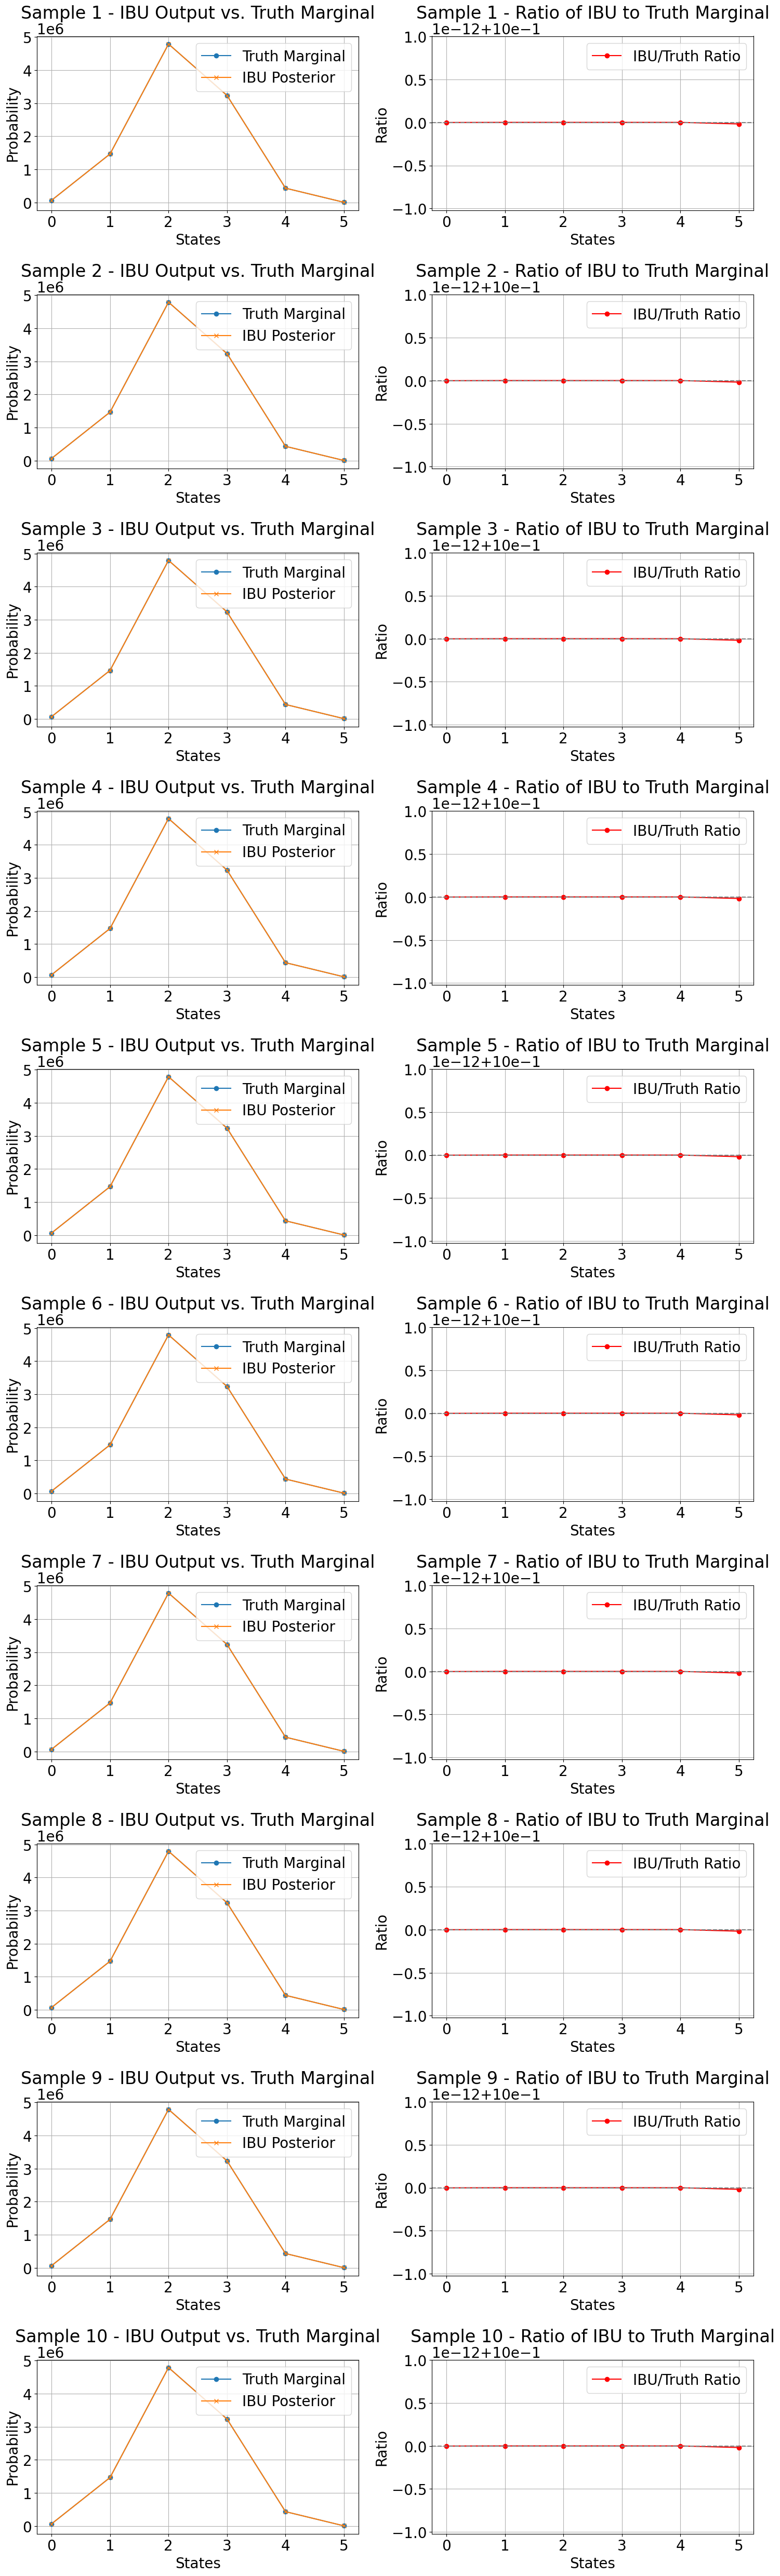

In [125]:
plt.figure(figsize=(15, 50))  # Adjust the figure size as needed

for i in range(n_iterations):
    truth_marginal = marginals['truth'][i]
    ibu = ibu_results['ibu'][i]
    ratio = ibu / truth_marginal

    # Create a subplot for each sample
    ax1 = plt.subplot(n_iterations, 2, 2*i + 1)  # 2 columns, n_samples rows, 1st column for i-th sample
    ax1.plot(truth_marginal, label='Truth Marginal', marker='o')
    ax1.plot(ibu, label='IBU Posterior', marker='x')
    ax1.set_title(f'Sample {i+1} - IBU Output vs. Truth Marginal')
    ax1.set_xlabel('States')
    ax1.set_ylabel('Probability')
    ax1.legend()
    ax1.grid(True)

    ax2 = plt.subplot(n_iterations, 2, 2*i + 2)  # 2nd column for i-th sample
    ax2.plot(ratio, label='IBU/Truth Ratio', marker='o', color='red')
    ax2.set_title(f'Sample {i+1} - Ratio of IBU to Truth Marginal')
    ax2.set_xlabel('States')
    ax2.set_ylabel('Ratio')
    ax2.axhline(y=1, color='gray', linestyle='--')  # Reference line at y=1
    ax2.legend()
    ax2.grid(True)

plt.tight_layout()  # Adjusts subplot params so that subplots are nicely fit in the figure area
plt.show()

In [126]:
bin_centers = 0.5 * (bins[:-1] + bins[1:])
last_center = 2 * bins[-1] - bin_centers[-1]
bin_centers = np.append(bin_centers, last_center)


In [127]:
ibu_array

array([[8.50163420e+04, 1.62155944e+06, 4.86748593e+06, 3.06255904e+06,
        3.60950679e+05, 2.42856342e+03],
       [8.44802701e+04, 1.62706748e+06, 4.86896137e+06, 3.05435997e+06,
        3.62491956e+05, 2.63895611e+03],
       [8.50568670e+04, 1.62445685e+06, 4.87126518e+06, 3.05624999e+06,
        3.60290001e+05, 2.68111132e+03],
       [8.68400958e+04, 1.62527649e+06, 4.87151899e+06, 3.05131073e+06,
        3.63097620e+05, 1.95607669e+03],
       [8.75239635e+04, 1.61984571e+06, 4.87221220e+06, 3.05732365e+06,
        3.60883256e+05, 2.21121856e+03],
       [8.57852383e+04, 1.62816965e+06, 4.86869533e+06, 3.05420863e+06,
        3.60666151e+05, 2.47499838e+03],
       [8.63141009e+04, 1.62344492e+06, 4.86931915e+06, 3.05516702e+06,
        3.63186798e+05, 2.56800738e+03],
       [8.71611026e+04, 1.61879221e+06, 4.88135267e+06, 3.04842376e+06,
        3.62159187e+05, 2.11106880e+03],
       [8.54985597e+04, 1.62169170e+06, 4.87034860e+06, 3.05934552e+06,
        3.60636663e+05, 

In [128]:
weighted_means = []
for ibu in ibu_results['ibu']:
    weighted_mean = np.sum(ibu * bin_centers) / np.sum(ibu) if np.sum(ibu) != 0 else 0
    weighted_means.append(weighted_mean)

weighted_means = np.array(weighted_means)
mean_of_weighted_means = np.mean(weighted_means)
uncertainty_in_mean = np.std(weighted_means)

print("Mean of weighted means across samples:", mean_of_weighted_means)
print("Uncertainty in the mean (standard deviation):", uncertainty_in_mean)


Mean of weighted means across samples: -0.006172971258511356
Uncertainty in the mean (standard deviation): 0.0003316396445815491


In [129]:
ibu_array = np.array(ibu_results['ibu'])

covariance_matrix = np.cov(ibu_array, rowvar=False)
print("Covariance matrix of IBU results across samples (bins):")
print(covariance_matrix)


Covariance matrix of IBU results across samples (bins):
[[ 1.00969344e+05  1.70621333e+05 -1.88316111e+05 -9.93208778e+04
   1.73517667e+04 -1.30545556e+03]
 [ 1.70621333e+05  8.07976000e+05 -8.35292667e+05  1.45761222e+05
  -2.81966111e+05 -7.09977778e+03]
 [-1.88316111e+05 -8.35292667e+05  2.14852822e+06 -1.01922311e+06
  -9.81380000e+04 -7.55833333e+03]
 [-9.93208778e+04  1.45761222e+05 -1.01922311e+06  1.03785201e+06
  -7.02983444e+04  5.22910000e+03]
 [ 1.73517667e+04 -2.81966111e+05 -9.81380000e+04 -7.02983444e+04
   4.27466011e+05  5.58467778e+03]
 [-1.30545556e+03 -7.09977778e+03 -7.55833333e+03  5.22910000e+03
   5.58467778e+03  5.14978889e+03]]


In [65]:
weighted_means.shape

(10,)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (5,) and arg 1 with shape (6,).

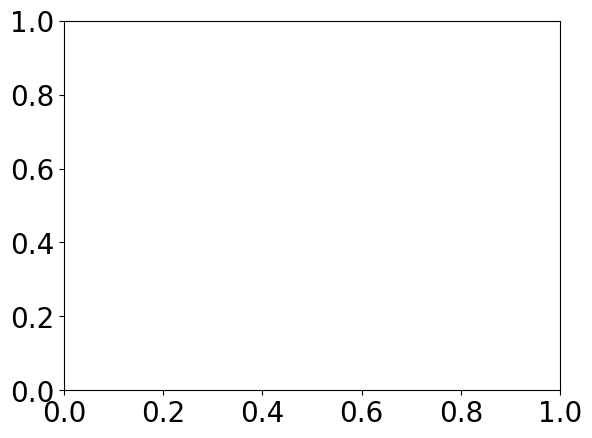

In [75]:
plt.bar(bins_midpoints, ibu, width=bin_widths, alpha=0.6, label='Normalized IBU')